## Reft + Vision (VLBart) experiments

Does ReFT works with Vision-language? Let's find out with the VQA Task.

### Imports

In [1]:
from trainer_base import TrainerBase
import torch.backends.cudnn as cudnn
import torch.multiprocessing as mp
import os
import collections
from pathlib import Path
from packaging import version

import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import shutil
from copy import deepcopy

from param import parse_args

from utils import LossMeter
from dist_utils import reduce_dict
import wandb

proj_dir = os.path.dirname(os.path.dirname(os.getcwd()))


_use_native_amp = False
_use_apex = False

# Check if Pytorch version >= 1.6 to switch between Native AMP and Apex
if version.parse(torch.__version__) < version.parse("1.6"):
    from transormers.file_utils import is_apex_available
    if is_apex_available():
        from apex import amp
    _use_apex = True
else:
    _use_native_amp = True
    from torch.cuda.amp import autocast

In [2]:
import transformers

from transformers.models.bart.modeling_bart import (
    BartConfig,
    ACT2FN,
    shift_tokens_right, _make_causal_mask, _expand_mask
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

from typing import Any, Callable, Dict, Iterable, List, Optional, Tuple
import copy

from transformers.modeling_outputs import Seq2SeqLMOutput

### 0. Prerequisites
- Install Pyvene and Pyreft with Python 3.8.
- Download all the training datasets using the following command:
    ```
    gdrive download 1O_RU1iFh_sbItZCTkOHUrbVIQQ_89Djj
    ```
    Here is the [google drive link](https://drive.google.com/file/d/1O_RU1iFh_sbItZCTkOHUrbVIQQ_89Djj/view), we suggest you use [gdrive](https://github.com/prasmussen/gdrive) to download it. Put the `datasets` folder directly under `image_video_text_understanding`.
- Download the image annotations as well by running `wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip`. Unzip and put the files in `image_video_text_understanding/datasets/COCO/images/`.

### 1. Reft Data (intervention locations)

Reft needs to populate `intervention_locations` together with the text input IDs and image embeddings. Here we calcluate the intervention locations.

The function `get_image_intervention_locations()` creates separate interventions for texts and image inputs. As a reminder, Vision-language Bart concatenates these location tokens together. However, image tokens are not visible to the VLBart model at the time of input (only text `input_ids` are visible). So the image interventions start at the end of `input_ids` and last for `args.n_boxes` long (image features are of length `args.n_boxes`). The number of image and text interventions match the number of interventions defined in the `ReftConfig` in section 1.3.1. We intervene on all encoder layers, and Bart encoder has 6 layers, so there will be 6 text and 6 image interventions if we share weights between the first and the last tokens. If we do not share weights, there will be 12 text and 12 image interventions.

In [3]:
IGNORE_INDEX = -100
from transformers import DataCollatorForSeq2Seq
import torch

def parse_positions(positions: str):
    # parse position
    first_n, last_n = 0, 0
    if "+" in positions:
        first_n = int(positions.split("+")[0].strip("f"))
        last_n = int(positions.split("+")[1].strip("l"))
    else:
        if "f" in positions:
            first_n = int(positions.strip("f"))
        elif "l" in positions:
            last_n = int(positions.strip("l"))
    return first_n, last_n

def get_image_intervention_locations(**kwargs):
    """
    This function generates separate intervention locations for images and texts.
    """
    # parse kwargs
    share_weights = kwargs["share_weights"] if "share_weights" in kwargs else False
    last_text_position = kwargs["last_position"]
    assert "image_positions" in kwargs, "Image positions must be provided"
    assert "positions" in kwargs, "Text positions must be provided"
    first_n, last_n = parse_positions(kwargs["positions"])
    first_image_n, last_image_n = parse_positions(kwargs["image_positions"])

    num_interventions = kwargs["num_interventions"]
    # `last_offset` is the length of the images (n_boxes).
    # Image tokens are concatenated to the end of the text tokens, i.e. after `last_position` tokens.
    # The true last position of the input is `last_position + last_offset`
    image_offset = kwargs["last_offset"] if "last_offset" in kwargs else 0

    pad_mode = kwargs["pad_mode"] if "pad_mode" in kwargs else "first"
    pad_position = -1 if pad_mode == "first" else last_text_position + image_offset
    if pad_mode != "first" and "nlvr" in kwargs["tasks"]:
        pad_position = last_text_position + 2 * image_offset

    if share_weights or ((first_n == 0 or last_n == 0) and (first_image_n == 0 or last_image_n == 0)):
        position_list = [i for i in range(first_n)] + \
            [i for i in range(last_text_position - last_n, last_text_position)]
        image_position_list = [i for i in range(last_text_position, last_text_position + first_image_n)] + \
            [i for i in range(last_text_position + image_offset - last_image_n, last_text_position + image_offset)]
        # There are 2 images in nlvr, so performing special treatment
        # For this notebook however, we only use vqa
        if "nlvr" in kwargs["tasks"]:
            image_position_list += [i for i in range(last_text_position + image_offset, last_text_position + image_offset + first_image_n)] + \
            [i for i in range(last_text_position + 2 * image_offset - last_image_n, last_text_position + 2 * image_offset)]
        text_len = len(position_list)
        image_len = len(image_position_list)
        if text_len > image_len:
            image_position_list += [pad_position for _ in range(text_len-image_len)]
        else:
            position_list += [pad_position for _ in range(image_len-text_len)]
        intervention_locations = [position_list]*(num_interventions//2) + \
            [image_position_list]*(num_interventions//2)
    else:
        assert first_n == last_n, "For now, we only support same first and last positions"
        left_intervention_locations = [i for i in range(first_n)]
        right_intervention_locations = [i for i in range(last_text_position - last_n, last_text_position)]
        left_image_intervention_locations = [i for i in range(last_text_position, last_text_position + first_image_n)]
        right_image_intervention_locations = [i for i in range(last_text_position + image_offset - last_image_n, last_text_position + image_offset)]
        if "nlvr" in kwargs["tasks"]:
            left_image_intervention_locations += [i for i in range(last_text_position + image_offset, last_text_position + image_offset + first_image_n)]
            right_image_intervention_locations += [i for i in range(last_text_position + 2 * image_offset - last_image_n, last_text_position + 2 * image_offset)]
        text_len = len(left_intervention_locations)
        image_len = len(left_image_intervention_locations)
        if text_len > image_len:
            left_image_intervention_locations += [pad_position for _ in range(text_len-image_len)]
            right_image_intervention_locations += [pad_position for _ in range(text_len-image_len)]
        else:
            left_intervention_locations += [pad_position for _ in range(image_len-text_len)]
            right_intervention_locations += [pad_position for _ in range(image_len-text_len)]

        intervention_locations = [left_intervention_locations]*(num_interventions//4) + \
            [right_intervention_locations]*(num_interventions//4) + \
            [left_image_intervention_locations]*(num_interventions//4) + \
            [right_image_intervention_locations]*(num_interventions//4)
    return intervention_locations


Here we also process intervention padding. To collate multiple interventions of different lengths, we create padding interventions that only intervene on padded locations. So these interventions do not impact Reft output. We only use `pad_mode = first`, so you can see that (1) a `1` is prepended to the input IDs at position 0 (2) padding interventions intervene on the position 0.

In [4]:
def compute_intervention(
    id: int, 
    result: dict, 
    tokenizer,
    fields_to_pad = [],
    fields_to_mask = [],
    **kwargs):
    pad_mode = kwargs["pad_mode"]
    # compute intervention locs
    assert "positions" in kwargs and "image_positions" in kwargs
    intervention_locations = get_image_intervention_locations(**kwargs)
    result["intervention_locations"] = intervention_locations
    result["id"] = id

    # add a single padding token BEFORE input_ids and fix everything
    if fields_to_pad is not None:
        if pad_mode == "first":
            for field in fields_to_pad:
                if field not in result:
                    continue
                if field == "labels":
                    result[field] = torch.cat((torch.tensor([IGNORE_INDEX,]), result[field]))
                else:
                    result[field] = torch.cat((torch.tensor([tokenizer.pad_token_id,]), result[field]))
            result["intervention_locations"] = (torch.IntTensor(result["intervention_locations"]) + 1).tolist()
            result["input_length"] += 1
        elif pad_mode == "last":
            for field in fields_to_pad:
                if field not in result:
                    continue
                if field == "labels":
                    result[field] = torch.cat((result[field], torch.tensor([IGNORE_INDEX,])))
                else:
                    result[field] = torch.cat((result[field], torch.tensor([tokenizer.pad_token_id,])))
            result["input_length"] += 1
        
    # attention masks
    if len(fields_to_mask) == 1:
        result["attention_mask"] = (result[fields_to_mask[0]] != tokenizer.pad_token_id).int()
    else:
        for field in fields_to_mask:
            result[f"{field}_mask"] = (result[field] != tokenizer.pad_token_id).int()

    # does not handle subspaces for now
    # print("Intervention Locations", result["intervention_locations"])
    return result

In [5]:
def reft_post_process(
    out_dict,
    tokenizer,
    idx: int, 
    last_position: int, 
    args = None,
    pad_mode = "none",
    fields_to_pad = [],
    fields_to_mask = []
):
    # print("Out_dict keys:", out_dict.keys())
    out_dict["instruction"] = tokenizer.decode(
        out_dict["input_ids"], skip_special_tokens=True)
    kwargs = {}
    if args is not None:
        if args.reft_rank != -1:
            kwargs["positions"] = args.positions
        if args.reft_image_rank != -1:
            kwargs["image_positions"] = args.image_positions
        kwargs["share_weights"] = args.share_weights
        layers = [int(l) for l in args.layers.split(";")]
        kwargs["num_interventions"] = len(layers) if args.share_weights else 2 * len(layers)
        # Double interventions if creating separate interventions for texts and images
        if args.reft_image_rank != -1 and args.reft_rank != -1:
            kwargs["num_interventions"] *= 2
        # `n_boxes` is the seq length of the image embeddings
        kwargs["last_offset"] = args.n_boxes
        # Only tested `first` 
        kwargs["pad_mode"] = pad_mode
        kwargs["last_position"] = last_position
        kwargs["tasks"] = args.prompt
    # print(kwargs)

    # print("BEFORE:", out_dict["input_ids"].shape, kwargs["last_position"])
    tokenized = compute_intervention(
            idx, 
            out_dict, 
            tokenizer,
            fields_to_pad,
            fields_to_mask,
            **kwargs)
    # print("AFTER:", tokenized["input_ids"].shape, tokenized["intervention_locations"])
    return tokenized

Here we collate the `intervention_locations` together with other collating fields, such as the image features, image positions (boxes - for some reason they are all zero tensors in both ReFT and DoRA), and labels. 

In [6]:
def keep_intervention_locations(datum):
    new_data = {}
    new_data["input_ids"] = datum["input_ids"]
    new_data["intervention_locations"] = datum["intervention_locations"]
    new_data["attention_mask"] = datum["attention_mask"]
    return new_data


def reft_supplemental_data_collator(batch, tokenizer):
    # Create padded `intervention_locations`
    intervene_batch = [keep_intervention_locations(item) for item in batch]
    # The normal data collator for collating other VLBart fields
    intervention_loc_collate_fn = DataCollatorForSeq2Seq(
        tokenizer=tokenizer,
        model=None,
        label_pad_token_id=-100,
        padding="longest"
    )
    
    intervene_batch_entry = intervention_loc_collate_fn(intervene_batch)

    batch_entry = {}
    id = []
    instructions = []
    # Collate `instruction` and `id`
    for i, entry in enumerate(batch):
        if 'instruction' in entry:
            instructions.append(entry['instruction'])
        if 'id' in entry:
            id.append(entry['id'])
    import numpy as np
    batch_entry['id'] = np.array(id)
    batch_entry['instruction'] = instructions
    
    # Pad `intervention_locations` with other stuff in the batch
    if "intervention_locations" in batch[0]:
        batch_entry["intervention_locations"] = intervene_batch_entry["intervention_locations"]
    return batch_entry


ReFT data adds the `intervention_locations` to the VQA fine-tune dataset. Here we add the ReFT specifics to the original VQA dataset (coming from DoRA/VLAdapter). 

`VQAFineTuneDataset` integrates with the CLIP features of COCO images. The VQA task contains the mapping from the answers to their labels in the `datasets/vqa/v2_mscoco_train2014_annotations.json` file, and the mapping from question IDs to answers in the `datasets/vqa/karpathy_train.json` file. The VQA images are from the COCO dataset, which should be placed separately in `datasets/COCO/clip_features/data_clip_RN101_att` and `datasets/COCO/clip_features/data_clip_RN101_fc`. You can download all the datasets using the following command:

```
gdrive download 1O_RU1iFh_sbItZCTkOHUrbVIQQ_89Djj
```

Here is the [google drive link](https://drive.google.com/file/d/1O_RU1iFh_sbItZCTkOHUrbVIQQ_89Djj/view), we suggest you use [gdrive](https://github.com/prasmussen/gdrive) to download it. Put the `datasets` folder directly under `image_video_text_understanding`.

In [7]:
from torch.utils.data import DataLoader, Dataset, Sampler
import vqa_clip_data as vqa_data

class ReftVQAFineTuneDataset(vqa_data.VQAFineTuneDataset):
    def __init__(self, split='train', raw_dataset=None, rank=-1, topk=-1, verbose=True, args=None, mode='train'):
        super().__init__(split, raw_dataset, rank, topk, verbose, args, mode)
        self.split = split
    
    def __getitem__(self, idx):

        out_dict = super().__getitem__(idx)

        out_dict["instruction"] = self.tokenizer.decode(
            out_dict['input_ids'], 
            skip_special_tokens=True
        )
        last_position = len(out_dict['input_ids']) - 1
        out_dict = reft_post_process(
            out_dict,
            self.tokenizer,
            idx,
            last_position,
            self.args,
            pad_mode="first",
            fields_to_pad=["input_ids"],
            fields_to_mask=["input_ids"]
        )

        return out_dict


    def collate_fn(self, batch):
        batch_entry = super().collate_fn(batch)
        # BEGIN ADD
        extra_batch = reft_supplemental_data_collator(batch, self.tokenizer)
        for k, v in extra_batch.items():
            batch_entry[k] = v
        # END ADD
        # print("LOGITS:", batch_entry["logits"])
        # print("LABELS:", batch_entry["labels"])
        if self.split == "karpathy_val" or self.split == "karpathy_test":
            print("In dataset:", batch_entry["instruction"], " ", batch_entry["question_ids"])

        return batch_entry



In [8]:
def get_loader(args, split='karpathy_train', mode='train',
               batch_size=32, workers=4, distributed=False, gpu=0, topk=-1):

    verbose = (gpu == 0)

    _dset = vqa_data.VQADataset(split, verbose)
    # print("Batch size:", batch_size, "Num workers:", workers, "Topk:", topk)

    dataset = ReftVQAFineTuneDataset(
        split,
        raw_dataset=_dset,
        rank=gpu,
        topk=topk,
        verbose=verbose,
        args=args,
        mode=mode)
    sampler = None

    if mode == 'train':
        loader = DataLoader(
            dataset, batch_size=batch_size, shuffle=(sampler is None),
            num_workers=workers, pin_memory=True, sampler=sampler,
            collate_fn=dataset.collate_fn)
    else:
        loader = DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=workers, pin_memory=True,
            sampler=sampler,
            shuffle=None if (sampler is not None) else False,
            collate_fn=dataset.collate_fn,
            drop_last=False)

    if verbose:
        loader.evaluator = vqa_data.VQAEvaluator(_dset)

    loader.task = 'vqa'

    return loader



### 2. Reft Model Replica for VLBart

The forward pass API of ReFT is different from normal - we also need to pass in `intervention_locations`. `VLBartReft` wraps up the `VLBart` model implementation in VLAdapter/DoRA with `intervention_locations` passed in.

In addition, we need to integrate ReFT's trainable parameters into VLBart Model's, so that gradient will propagate.

In [9]:
from modeling_bart import VLBart
class VLBartReft(VLBart):
    def __init__(self, config: BartConfig):
        super().__init__(config)
        from pyreft import get_reft_model
        self.intervenable = get_reft_model(self.model, config.reft_config)
        # print("Reft parameters:", self.intervenable.interventions)
        # self.intervenable.unfreeze_intervention_parameters()
        self.intervenable.print_trainable_parameters()
        # print("INTERVENABLE:", self.intervenable.model)

        # Unfreeze the PyVene intervention parameters
        for k, v in self.intervenable.unfreeze_intervention_parameters().items():
            n = k.replace(".", "#")
            print(n)
            self.register_parameter(n, v)
    
    def forward(
        self,
        input_ids=None,
        attention_mask=None,

        vis_inputs=None,
        vis_attention_mask=None,

        decoder_input_ids=None,
        decoder_attention_mask=None,
        encoder_outputs=None,
        past_key_values=None,
        inputs_embeds=None,
        decoder_inputs_embeds=None,
        labels=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        task=None,

        reduce_loss=False,
        intervention_locations = None,
        **kwargs,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if labels is not None:
            if decoder_input_ids is None:
                decoder_input_ids = shift_tokens_right(
                    labels, self.config.pad_token_id, self.config.decoder_start_token_id
                )
        
        if intervention_locations is not None:
            # print("Intervention locs not None")
            # Pyvene forward pass
            intervention_locations = intervention_locations.clone().detach().permute(1, 0, 2)
            _, outputs = self.intervenable(
                {
                    "input_ids": input_ids,
                    "attention_mask": attention_mask,
                    "vis_inputs": vis_inputs,
                    "vis_attention_mask": vis_attention_mask,
                    "decoder_input_ids": decoder_input_ids,
                    "decoder_attention_mask": decoder_attention_mask,
                    "encoder_outputs": encoder_outputs,
                    "past_key_values": past_key_values,
                    "inputs_embeds": inputs_embeds,
                    "decoder_inputs_embeds": decoder_inputs_embeds,
                    "output_attentions": output_attentions,
                    "output_hidden_states": output_hidden_states,
                    "task": task,
                    "return_dict": return_dict,
                },
                unit_locations={"sources->base": (
                    None,
                    intervention_locations
                )},
                labels=labels,
                return_dict=False,
                subspaces=None,
                use_cache=use_cache,
            )
        else:
            # print("Intervention locs None")
            outputs = self.model(
                input_ids,
                attention_mask=attention_mask,

                vis_inputs=vis_inputs,
                vis_attention_mask=vis_attention_mask,

                decoder_input_ids=decoder_input_ids,
                encoder_outputs=encoder_outputs,
                decoder_attention_mask=decoder_attention_mask,
                past_key_values=past_key_values,
                inputs_embeds=inputs_embeds,
                decoder_inputs_embeds=decoder_inputs_embeds,
                use_cache=use_cache,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
                task=task,
            )

        # print("Outputs:", outputs)
        lm_logits = self.lm_head(outputs[0]) + self.final_logits_bias
        
        masked_lm_loss = None
        # print("LOGITS:", lm_logits)
        # print("LABELS", labels)
        if labels is not None:
            # loss_fct = CrossEntropyLoss()
            if reduce_loss:
                loss_fct = CrossEntropyLoss(ignore_index=-100)
            else:
                loss_fct = CrossEntropyLoss(ignore_index=-100, reduction='none')
            masked_lm_loss = loss_fct(lm_logits.view(-1, self.config.vocab_size), labels.view(-1))
            
        if not return_dict:
            output = (lm_logits,) + outputs[1:]
            return ((masked_lm_loss,) + output) if masked_lm_loss is not None else output

        # if masked_lm_loss is not None and len(masked_lm_loss) > 1:
        #     masked_lm_loss = masked_lm_loss[0]
        # print("LOSS 0:", masked_lm_loss)

        return Seq2SeqLMOutput(
            loss=masked_lm_loss,
            logits=lm_logits,
            past_key_values=outputs.past_key_values,
            decoder_hidden_states=outputs.decoder_hidden_states,
            decoder_attentions=outputs.decoder_attentions,
            cross_attentions=outputs.cross_attentions,
            encoder_last_hidden_state=outputs.encoder_last_hidden_state,
            encoder_hidden_states=outputs.encoder_hidden_states,
            encoder_attentions=outputs.encoder_attentions,
        )



Here we calculate the VQA training loss (whether the model output matches the label, weighted by the score). We also specify the correct VQA generation parameters here. 

In [10]:
class VLBartVQA(VLBartReft):
    def __init__(self, config, num_answers=None, label2ans=None):
        super().__init__(config)

        self.num_answers = num_answers
        self.label2ans = label2ans
        self.bce_loss = nn.BCEWithLogitsLoss()

    def train_step(self, batch):

        device = next(self.parameters()).device

        batch = self.vis_forward(batch, device)
        task = batch["task"]

        vis_feats = batch['vis_feats'].to(device)
        input_ids = batch['input_ids'].to(device)
        vis_pos = batch['boxes'].to(device)
        intervention_locations = batch['intervention_locations'].to(device)

        lm_labels = batch["target_ids"].to(device)

        output = self(
            input_ids=input_ids,
            vis_inputs=(vis_feats, vis_pos),
            labels=lm_labels,
            return_dict=True,
            task=task,
            intervention_locations=intervention_locations
        )
        assert 'loss' in output

        lm_mask = (lm_labels != -100).float()
        B, L = lm_labels.size()

        loss = output['loss']

        loss = loss.view(B, L) * lm_mask

        loss = loss.sum(dim=1) / lm_mask.sum(dim=1).clamp(min=1)  # B

        loss = loss * batch['scores'].to(device=device)

        loss = loss.mean()
        
        # print("LOSS 1:", batch["scores"], loss.item())
        result = {
            'loss': loss
        }

        return result

    @torch.no_grad()
    def test_step(self, batch, **kwargs):
        self.eval()
        device = next(self.parameters()).device

        batch = self.vis_forward(batch, device)

        vis_feats = batch['vis_feats'].to(device)
        input_ids = batch['input_ids'].to(device)
        vis_pos = batch['boxes'].to(device)
        task = batch["task"]
        intervention_locations = batch['intervention_locations'].to(device)

        result = {}
        generation_args = {
            "base": {
                "input_ids":input_ids,
                "vis_inputs":(vis_feats, vis_pos),
                "task":task,
                **kwargs
            },
            "unit_locations": {"sources->base": (None, 
                intervention_locations.permute(1, 0, 2))},
            "intervene_on_prompt": True,
            "eos_token_id": self.tokenizer.eos_token_id,
            "early_stopping": True,
            "model": self,
        }
        # print("Generating...", input_ids.shape, intervention_locations)
        # TODO: temperature, top_p, top_k
        # print("GENERATE MODEL:", self.intervenable.model)
        _, output = self.intervenable.generate(**generation_args)
        generated_sents = self.tokenizer.batch_decode(output, skip_special_tokens=True)
        result['token_ids'] = output
        result['pred_ans'] = generated_sents

        return result



### 3. Multitask VLBart Trainer

#### 1.3.1 ReftConfig

ReFT model needs `ReftConfig` to properly initialize. Here we specify the text and image intervention specs. They are all separate.

Also, we change the weight decay of ReFT parameters to 0. ReFT does not like wd, but other parameters in the training of VLBart do (visual embeddings, layer norms, for example).

In [11]:
from pyreft import ReftConfig, LoreftIntervention, TaskType

class ReftTrainer(TrainerBase):
    def __init__(self, args, train_loader=None, val_loader=None, test_loader=None, train=True):
        super().__init__(
            args,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            train=train)

    def create_reft_config(self, config):
        args = self.args
        layers = args.layers
        # ReFT layers - right now only "all" works properly
        # TODO: properly process "layers" when it is not "all"
        if layers != "all":
            layers = [int(l) for l in layers.split(";")]
        else:
            layers = [l for l in range(config.num_hidden_layers)]
        if '+' in self.args.positions and not args.share_weights:
            layers += layers
        
        image_rank = args.reft_image_rank
        text_rank = args.reft_rank
        embed_dim = args.mid_dim

        # print("REFT PARAMS:",embed_dim, rank, args.dropout)
        representations = []
        # Text interventions
        if text_rank != -1:
            representations += [{
                "layer": l, "component": "block_output",
                "low_rank_dimension": text_rank,
                "intervention": LoreftIntervention(
                    embed_dim=embed_dim, low_rank_dimension=text_rank,
                    dropout=args.reft_dropout, dtype=torch.float32, act_fn=None, device="cuda",
                    add_bias=True
                )
            } for l in layers]
        # Image interventions
        if image_rank != -1:
            representations += [{
                "layer": l, "component": "block_output",
                "low_rank_dimension": image_rank,
                "intervention": LoreftIntervention(
                    embed_dim=embed_dim, low_rank_dimension=image_rank,
                    dropout=args.reft_image_dropout, dtype=torch.float32, act_fn=None, device="cuda",
                    add_bias=True
                )
            } for l in layers]
        reft_config = ReftConfig(representations=representations)
        print(reft_config)
        return reft_config

    def create_config(self):
        config = super().create_config()
        setattr(config, "reft_config", self.create_reft_config(config))
        return config

    def create_optimizer_and_scheduler(self):
        if self.verbose:
            print('Building Optimizer')

        lr_scheduler = None

        from transformers.optimization import AdamW, get_linear_schedule_with_warmup

        # Added "#unit#pos" to `no_decay` to keep ReFT intervention's weight decay to 0
        # Bart's bias and layer norm's weight decay is 0, others are not zero 
        no_decay = ["bias", "LayerNorm.weight", "#unit#pos"]

        if 'adamw' in self.args.optim:
            optimizer_grouped_parameters = [
                {
                    "params": [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
                    "weight_decay": self.args.weight_decay,
                },
                {
                    "params": [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)],
                    "weight_decay": 0.0,
                },
            ]
            optim = AdamW(optimizer_grouped_parameters,
                        lr=self.args.lr, eps=self.args.adam_eps)

        else:
            # print("Parameters:", self.model.named_parameters())
            optimizer_grouped_parameters = [
                {
                    "params": [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
                    "weight_decay": self.args.weight_decay,
                },
                {
                    "params": [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)],
                    "weight_decay": 0.0,
                },
            ]
            optim = self.args.optimizer(optimizer_grouped_parameters, self.args.lr)

        batch_per_epoch = len(self.train_loader)
        t_total = batch_per_epoch // self.args.gradient_accumulation_steps * self.args.epochs
        warmup_ratio = self.args.warmup_ratio
        warmup_iters = int(t_total * warmup_ratio)
        if self.verbose:
            print("Batch per epoch: %d" % batch_per_epoch)
            print("Total Iters: %d" % t_total)
            print('Warmup ratio:', warmup_ratio)
            print("Warm up Iters: %d" % warmup_iters)

        lr_scheduler = get_linear_schedule_with_warmup(optim, warmup_iters, t_total)

        return optim, lr_scheduler

#### 1.3.2 Reft images trainer

This class is a complete VLBart trainer, integrated with ReFT. We

- Unfreezed ReFT's parameters
- Updated the model's config with ReFT
- Performed gradient clipping (needed for visual embeddings)


In [12]:
class Trainer(ReftTrainer):
    def __init__(self, args, train_loader=None, val_loader=None, test_loader=None, train=True):
        super().__init__(
            args,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            train=train)

        model_kwargs = {}
        if 'bart' in args.backbone:
            model_class = VLBartVQA

        config = self.create_config()
        self.tokenizer = self.create_tokenizer()

        if 'bart' in self.args.tokenizer:
            num_added_toks = 0
            if config.use_vis_order_embedding:
                additional_special_tokens = [f'<extra_id_{i}>' for i in range(100-1, -1, -1)] + \
                        [f'<vis_extra_id_{i}>' for i in range(100-1, -1, -1)]
                special_tokens_dict = {'additional_special_tokens': additional_special_tokens}
                num_added_toks = self.tokenizer.add_special_tokens(special_tokens_dict)

                config.default_obj_order_ids = self.tokenizer.convert_tokens_to_ids([f'<vis_extra_id_{i}>' for i in range(100)])

        self.model = self.create_model(model_class, config, **model_kwargs)

        if 't5' in self.args.tokenizer:
            self.model.resize_token_embeddings(self.tokenizer.vocab_size)
        elif 'bart' in self.args.tokenizer:
            self.model.resize_token_embeddings(self.model.model.shared.num_embeddings + num_added_toks)

        self.model.tokenizer = self.tokenizer
        if 't5' in self.args.tokenizer or 'bart' in self.args.tokenizer:
            self.model.true_id = self.tokenizer('true', add_special_tokens=False).input_ids[0]
            self.model.false_id = self.tokenizer('false', add_special_tokens=False).input_ids[0]

        # Load Checkpoint
        self.start_epoch = None
        if args.load is not None:
            ckpt_path = args.load
            self.load_checkpoint(ckpt_path)
        if self.args.from_scratch:
            self.init_weights()

        # GPU Options
        print(f'Model Launching at GPU {self.args.gpu}')
        if self.verbose:
            from time import time
            start = time()
        self.model = self.model.to(args.gpu)
        
        # Only thing changed: set device to cuda, and unfreeze ReFT params

        self.model.intervenable.set_device(self.model.model.device)

        self.freeze_whole_model() # freeze whole parameters first
        self.unfreeze_parameters() # unfreeze selected parameters
        self.model.intervenable.unfreeze_intervention_parameters()
        # print(self.model)
        self.percent_updated_parameters = self.print_trainable_params_percentage(self.model)

        # Optimizer
        if train:
            self.optim, self.lr_scheduler = self.create_optimizer_and_scheduler()

            if self.args.fp16 and _use_native_amp:
                self.scaler = torch.cuda.amp.GradScaler()
            elif _use_apex:
                self.model, self.optim = amp.initialize(
                    self.model, self.optim, opt_level='O1', verbosity=self.verbose)

        if self.verbose:
            print(f'It took {time() - start:.1f}s')

    def train(self):
        if self.verbose:
            vqa_loss_meter = LossMeter()
            # best_eval_loss = 9595.
            quesid2ans = {}
            best_vqa_valid = 0.
            best_vqa_epoch = 0

            wandb.init(project=self.args.project_name)
            wandb.run.name = self.args.run_name
            wandb.config.update(self.args)
            wandb.watch(self.model)
            wandb.log(
                {"percent of updated parameters (%)": self.percent_updated_parameters}
            )

            src_dir = os.path.dirname(os.getcwd())
            base_path = os.path.dirname(src_dir)
            src_dir = str(src_dir)
            wandb.save(os.path.join(src_dir + "/*.py"), base_path=base_path)

        global_step = 0
        for epoch in range(self.args.epochs):
            if self.start_epoch is not None:
                epoch += self.start_epoch
            self.model.train()
            self.partial_eval()

            if self.verbose:
                pbar = tqdm(total=len(self.train_loader), ncols=250)

            epoch_results = {
                'loss': 0.,
            }

            task_counter = {
                'vqa': 0,
            }

            # vqa
            quesid2ans = {}
            train_acc = 0.
            # train_acc_steps = int(len(self.train_loader) * 0.05)
            # last_acc_step = 0

            for step_i, batch in enumerate(self.train_loader):

                # print(f'GPU{self.args.gpu} inside training loop')
                # print(batch)
                task = batch['task']
                # if self.verbose:
                #     print('task', task)
                task_counter[task] += 1

                batch['log_train_accuracy'] = self.args.log_train_accuracy

                # self.optim.zero_grad()
                if self.args.fp16 and _use_native_amp:
                    with autocast():
                        results = self.model.train_step(batch)
                else:
                    results = self.model.train_step(batch)

                loss = results['loss']

                if self.args.fp16 and _use_native_amp:
                    self.scaler.scale(loss).backward()
                elif self.args.fp16 and _use_apex:
                    with amp.scale_loss(loss, self.optim) as scaled_loss:
                        scaled_loss.backward()
                else:
                    loss.backward()

                # print(f'GPU{self.args.gpu} after backward')

                loss = loss.detach()

                # Update Parameters
                if self.args.clip_grad_norm > 0:
                    if self.args.fp16 and _use_native_amp:
                        self.scaler.unscale_(self.optim)
                        torch.nn.utils.clip_grad_norm_(
                            self.model.parameters(), self.args.clip_grad_norm)
                    elif self.args.fp16 and _use_apex:
                        torch.nn.utils.clip_grad_norm_(amp.master_params(
                            self.optim), self.args.clip_grad_norm)
                    else:
                        torch.nn.utils.clip_grad_norm_(
                            self.model.parameters(), self.args.clip_grad_norm)

                if self.args.fp16 and _use_native_amp:
                    self.scaler.step(self.optim)
                    self.scaler.update()
                else:
                    self.optim.step()

                if self.lr_scheduler:
                    self.lr_scheduler.step()
                for param in self.model.parameters():
                    param.grad = None

                global_step += 1

                for k, v in results.items():
                    if k in epoch_results:
                        epoch_results[k] += v.item()

                if self.lr_scheduler:
                    if version.parse(torch.__version__) >= version.parse("1.4"):
                        lr = self.lr_scheduler.get_last_lr()[0]
                    else:
                        lr = self.lr_scheduler.get_lr()[0]
                else:
                    try:
                        lr = self.optim.get_lr()[0]
                    except AttributeError:
                        lr = self.args.lr

                if self.verbose:
                    if task == 'vqa':
                        vqa_loss_meter.update(loss.item())

                    desc_str = f'Epoch {epoch} | LR {lr:.6f}'

                    desc_str += f" |"
                    if 'vqa' in self.args.tasks:
                        desc_str += f" VQA {task_counter['vqa']}"
                    if len(vqa_loss_meter) > 0:
                        desc_str += f' | VQA Loss {vqa_loss_meter.val:4f}'

                    pbar.set_description(desc_str)
                    pbar.update(1)

            if self.verbose:
                pbar.close()

            if self.args.log_train_accuracy:
                train_score_dict = {
                    'n_correct': n_correct,
                    'n_total': n_total
                }
                train_score_dict = reduce_dict(train_score_dict, self.args.gpu)

            if self.verbose:
                # Validation
                log_str = ''
                wandb_log_dict = {}

                if 'vqa' in self.args.tasks:
                    # VQA
                    vqa_val_loader = self.val_loader['vqa']
                    score_dict = self.vqa_evaluate(vqa_val_loader)
                    valid_score = score_dict['topk_score'] * 100.
                    valid_score_raw = score_dict['overall']
                    if valid_score_raw > best_vqa_valid or epoch == 0:
                        best_vqa_valid = valid_score_raw
                        best_vqa_epoch = epoch
                        # self.save("VQA_BEST")
                    log_str += f"VQA"
                    log_str += "\nEpoch %d: Valid Raw %0.2f Topk %0.2f" % (epoch, valid_score_raw, valid_score)
                    log_str += "\nEpoch %d: Best Raw %0.2f\n" % (best_vqa_epoch, best_vqa_valid)
                    wandb_log_dict['VQA/Valid/score'] = valid_score
                    wandb_log_dict['VQA/Valid/raw_score'] = score_dict['overall']
                
                wandb.log(wandb_log_dict, step=epoch)

                print(log_str)

        # Test Set
        if self.verbose:
            self.save("LAST")

            log_str = ''
            wandb_log_dict = {}

            if 'vqa' in self.args.tasks:
                # VQA
                vqa_test_loader = self.test_loader['vqa']
                evaluator = vqa_test_loader.evaluator
                dump_path = os.path.join(self.args.output, 'karpathy_test_predict.json')
                quesid2ans = self.vqa_predict(vqa_test_loader, dump_path)
                wandb.save(dump_path, base_path=self.args.output)

                acc_dict_all = evaluator.evaluate_raw(quesid2ans)
                acc_dict_answerable = evaluator.evaluate_raw(quesid2ans, is_topk_optimal=True)
                acc_dict_unanswerable = evaluator.evaluate_raw(quesid2ans, is_topk_optimal=False)

                wandb_log_dict['VQA/Test/overall'] = acc_dict_all['overall']
                wandb_log_dict['VQA/Test/topk_optimal'] = acc_dict_answerable['overall']
                wandb_log_dict['VQA/Test/topk_not_optimal'] = acc_dict_unanswerable['overall']

                if self.test_loader.get("vqa_submit", None):
                    vqa_submit_test_loader = self.test_loader['vqa_submit']
                    dump_path = os.path.join(self.args.output, 'vqa_submit.json')
                    self.vqa_predict(vqa_submit_test_loader, dump_path=dump_path)
                    wandb.save(dump_path, base_path=self.args.output)

            print(log_str)
            wandb.log(wandb_log_dict, step=self.args.epochs)

            wandb.log({'finished': True})

    def vqa_predict(self, loader, dump_path=None):
        self.model.eval()
        with torch.no_grad():
            quesid2ans = {}

            gen_kwargs = {}
            gen_kwargs['num_beams'] = 1

            for i, batch in enumerate(tqdm(loader, ncols=150, desc="VQA Validation")):

                if self.args.distributed:
                    results = self.model.module.test_step(batch, **gen_kwargs)
                else:
                    results = self.model.test_step(batch, **gen_kwargs)

                pred_ans = results['pred_ans']
                ques_ids = batch['question_ids']

                for qid, ans in zip(ques_ids, pred_ans):
                    quesid2ans[qid] = ans

            if dump_path is not None:
                loader.evaluator.dump_result(quesid2ans, dump_path)
            return quesid2ans

    def vqa_evaluate(self, loader, dump_path=None):
        evaluator = loader.evaluator
        quesid2ans = self.vqa_predict(loader, dump_path)

        acc_dict = evaluator.evaluate_raw(quesid2ans)

        topk_score = evaluator.evaluate(quesid2ans)
        acc_dict['topk_score'] = topk_score

        return acc_dict

### 4. Main Worker, Params, and Run

Here we specify all the parameters for VLBart and ReFT. Note that we unfroze the bias and the layer norms, as well as the visual embeddings. For the detailed modules that we tune, see `trainer_base.py`.

In [13]:
cudnn.benchmark = True
args = parse_args(False)
ngpus_per_node = torch.cuda.device_count()
args.world_size = ngpus_per_node

In [14]:
args.distributed = False
args.nproc_per_node = 1
args.master_port = 26464
args.multiGPU = True
args.optim = "adamw"
args.warmup_ratio = 0.1
args.clip_grad_norm = 5
args.weight_decay = 0.01
args.lr = 1e-3
args.epochs = 3
args.num_workers = 4
args.backbone = "facebook/bart-base"
args.output = "snap/VLBart_dora_reft/test/"
args.num_beams = 5
args.use_tasks_prompts = True
args.train_topk = 10000
args.valid_topk = 4
args.batch_size = 100
args.valid_batch_size = 1
# args.use_dora = True
args.unfreeze_bias = True
args.unfreeze_layer_norms = True
# args.lora_settings = True
# args.lora_dim = 128
args.tasks = "vqa"
args.dropout = 0.00
args.reft_dropout = 0.00
args.reft_image_dropout = 0.00
args.reft_rank = 4
args.reft_image_rank = 64
args.positions = "f3+l3"
args.image_positions = "f3+l3"

args.feature = "RN101"
args.n_boxes = 36
args.downsample = True
args.image_size = "(224,224)"
args.project_name = "Test"
args.run_name = "tune+lr1e-3"
args.local_rank = 0
args.feature_type = "RN101"
os.environ['RANK'] = '0'
os.environ['WORLD_SIZE'] = '1'
os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = '26464'

In [15]:
# cudnn.benchmark = True
# args = parse_args(False)
ngpus_per_node = torch.cuda.device_count()
args.world_size = ngpus_per_node
if args.local_rank in [0, -1]:
    print(args)

    comments = []
    if args.load is not None:
        ckpt_str = "_".join(args.load.split('/')[-3:])
        comments.append(ckpt_str)
    if args.comment != '':
        comments.append(args.comment)
    comment = '_'.join(comments)

    from datetime import datetime
    current_time = datetime.now().strftime('%b%d_%H-%M')
    run_name = f'{current_time}_GPU{args.world_size}'
    if len(comments) > 0:
        run_name += f'_{comment}'

    if args.run_name == "":
        args.run_name = run_name

Configurations
{'adam_beta1': 0.9,
 'adam_beta2': 0.999,
 'adam_eps': 1e-06,
 'add_adapter_cross_attn': True,
 'add_layer_norm_after_adapter': False,
 'add_layer_norm_before_adapter': False,
 'additional_visual_embedding_layers': 0,
 'answer_normalize': False,
 'backbone': 'facebook/bart-base',
 'batch_size': 100,
 'caption_cocoonly': True,
 'caption_only': False,
 'classifier': False,
 'clip_grad_norm': 5,
 'cls_task': 'tinyimagenet',
 'coco_only': False,
 'comment': '',
 'decoder_prompt_len': 0,
 'deepspeed': None,
 'distributed': False,
 'do_lower_case': False,
 'dora_simple': False,
 'downsample': True,
 'dropout': 0.0,
 'dry': False,
 'efficient_unique_hyper_net': False,
 'encoder_prompt_len': 0,
 'epochs': 3,
 'expand_vis_embedding': False,
 'factorized_phm': True,
 'feat_dim': 2048,
 'feature': 'RN101',
 'feature_type': 'RN101',
 'fp16': False,
 'freeze_bn_statistics': False,
 'freeze_ln_statistics': False,
 'from_scratch': False,
 'gen_max_length': 20,
 'gradient_accumulation_s

In [16]:
# GPU is assigned
gpu = args.local_rank
args.gpu = gpu
args.rank = gpu
print(f'Launching at GPU {gpu}')

print(f"args.feature_type {args.feature_type}")
feat_dim_dict = {
    "RN50": 2048,
    "RN101": 2048,
    "RN50x4": 2560,
    "ViT": 768
}
args.feat_dim = feat_dim_dict[args.feature_type]

vqa_args = deepcopy(args)
vqa_args.max_text_length = 20


if args.use_tasks_prompts:
    vqa_args.prompt = "vqa: "
else:
    vqa_args.prompt = ""

Launching at GPU 0
args.feature_type RN101


Now we create the data loaders.

In [17]:

train_loaders = []

train_loader = get_loader(
    vqa_args,
    split='karpathy_train', mode='train', batch_size=vqa_args.batch_size,
    distributed=False, gpu=args.gpu,
    workers=args.num_workers,
    topk=args.train_topk,
)

val_num_workers = 4
# Validation set
if gpu == 0:
    val_loader = {}
    if args.epochs > 0:
        if 'vqa' in args.tasks:
            print(f'Building VQA val loader at GPU {gpu}')
            vqa_val_loader = get_loader(
                vqa_args,
                split='karpathy_val', mode='val', batch_size=vqa_args.valid_batch_size,
                distributed=False, gpu=args.gpu,
                workers=val_num_workers,
                topk=args.valid_topk,
            )
            val_loader['vqa'] = vqa_val_loader

    # Test set
    test_loader = {}
    if 'vqa' in args.tasks:
        print(f'Building VQA test loader at GPU {gpu}')
        vqa_test_loader = get_loader(
            vqa_args,
            split='karpathy_test', mode='val', batch_size=vqa_args.valid_batch_size,
            distributed=False, gpu=args.gpu,
            workers=val_num_workers,
            topk=args.valid_topk,
        )
        test_loader['vqa'] = vqa_test_loader

        if args.testing:
            vqa_submit_test_loader = get_loader(
                vqa_args,
                split='test_4', mode='val', batch_size=vqa_args.valid_batch_size,
                distributed=False, gpu=args.gpu,
                workers=val_num_workers,
                topk=args.valid_topk,
            )
            test_loader['vqa_submit'] = vqa_submit_test_loader
else:
    val_loader = None
    test_loader = None


Load 605102 data from split(s) karpathy_train.
# Answers: 3129
Data sources:  ['karpathy_train']


/nlp/scr/peterwz/miniconda3/envs/peterwz-test-dora/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded 605102 data from karpathy_train
Use only 10000 data
# all sentences: 10000
Building VQA val loader at GPU 0


/nlp/scr/peterwz/miniconda3/envs/peterwz-test-dora/lib/python3.8/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Load 26729 data from split(s) karpathy_val.
# Answers: 3129
Data sources:  ['karpathy_val']
Loaded 26729 data from karpathy_val
Use only 4 data
# all sentences: 4
Building VQA test loader at GPU 0
Load 26280 data from split(s) karpathy_test.
# Answers: 3129
Data sources:  ['karpathy_test']
Loaded 26280 data from karpathy_test
Use only 4 data
# all sentences: 4


Now we start training!

In [18]:

trainer = Trainer(args, train_loader, val_loader, test_loader, train=True)

trainer.train()

IntervenableConfig
{
    "model_type": "None",
    "representations": [
        {
            "layer": 0,
            "component": "block_output",
            "unit": "pos",
            "max_number_of_units": 1,
            "low_rank_dimension": 4,
            "intervention_type": null,
            "intervention": "PLACEHOLDER",
            "subspace_partition": null,
            "group_key": null,
            "intervention_link_key": null,
            "moe_key": null,
            "source_representation": null,
            "hidden_source_representation": null
        },
        {
            "layer": 1,
            "component": "block_output",
            "unit": "pos",
            "max_number_of_units": 1,
            "low_rank_dimension": 4,
            "intervention_type": null,
            "intervention": "PLACEHOLDER",
            "subspace_partition": null,
            "group_key": null,
            "intervention_link_key": null,
            "moe_key": null,
            "source_r

Some weights of VLBartVQA were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['layer#3#comp#block_output#unit#pos#nunit#1#0#rotate_layer#parametrizations#weight#original', 'layer#1#comp#block_output#unit#pos#nunit#1#1#learned_source#weight', 'layer#0#comp#block_output#unit#pos#nunit#1#3#learned_source#bias', 'encoder.visual_embedding.feat_embedding.0.bias', 'layer#2#comp#block_output#unit#pos#nunit#1#2#rotate_layer#parametrizations#weight#original', 'layer#0#comp#block_output#unit#pos#nunit#1#1#learned_source#bias', 'layer#5#comp#block_output#unit#pos#nunit#1#3#learned_source#bias', 'encoder.visual_embedding.feat_embedding.0.weight', 'layer#0#comp#block_output#unit#pos#nunit#1#1#learned_source#weight', 'layer#1#comp#block_output#unit#pos#nunit#1#0#learned_source#bias', 'intervenable.model.encoder.visual_embedding.feat_embedding.1.weight', 'layer#2#comp#block_output#unit#pos#nunit#1#3#learned_source#bias', 'layer#1#comp#block_output#unit#pos#

Model Launching at GPU 0
model.encoder.visual_embedding.feat_embedding.0.weight is trainable...
model.encoder.visual_embedding.feat_embedding.0.bias is trainable...
model.encoder.visual_embedding.feat_embedding.1.weight is trainable...
model.encoder.visual_embedding.feat_embedding.1.bias is trainable...
layer#0#comp#block_output#unit#pos#nunit#1#0#learned_source#bias is trainable...(4)
layer#1#comp#block_output#unit#pos#nunit#1#0#learned_source#bias is trainable...(4)
layer#2#comp#block_output#unit#pos#nunit#1#0#learned_source#bias is trainable...(4)
layer#3#comp#block_output#unit#pos#nunit#1#0#learned_source#bias is trainable...(4)
layer#4#comp#block_output#unit#pos#nunit#1#0#learned_source#bias is trainable...(4)
layer#5#comp#block_output#unit#pos#nunit#1#0#learned_source#bias is trainable...(4)
layer#0#comp#block_output#unit#pos#nunit#1#1#learned_source#bias is trainable...(4)
layer#1#comp#block_output#unit#pos#nunit#1#1#learned_source#bias is trainable...(4)
layer#2#comp#block_outp

/nlp/scr/peterwz/miniconda3/envs/peterwz-test-dora/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Currently logged in as: peterzw494 (peterwz). Use `wandb login --relogin` to force relogin


wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.
  0%|                                                                                                                                                                                                                             | 0/100 [00:00<?, ?it/s]/nlp/scr/peterwz/miniconda3/envs/peterwz-test-dora/lib/python3.8/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/nlp/scr/peterwz/miniconda3/envs/peterwz-test-dora/lib/python3.8/site-packages/pyvene/models/modeling_utils.py:288: UserWarning: To cop

In dataset: ['vqa: Will this kid leave the powdered sugar on his face?']   In dataset:[393243000]In dataset:
 ['vqa: Is this person wearing a tie?']  ['vqa: What is the child eating?']  In dataset:  [393243002]  
[393243001]['vqa: What color is the kids hair?']   [393243003]



/nlp/scr/peterwz/miniconda3/envs/peterwz-test-dora/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
/nlp/scr/peterwz/miniconda3/envs/peterwz-test-dora/lib/python3.8/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 3274.88it/s]


VQA
Epoch 0: Valid Raw 47.50 Topk 47.50
Epoch 0: Best Raw 47.50



  0%|                                                                                                                                                                                                                             | 0/100 [00:00<?, ?it/s]wandb: WARNING Step only supports monotonically increasing values, use define_metric to set a custom x axis. For details see: https://wandb.me/define-metric
wandb: WARNING (User provided step: 0 is less than current step: 1. Dropping entry: {'VQA/Valid/score': 47.5, 'VQA/Valid/raw_score': 47.5, '_timestamp': 1720474146.5149028}).
Epoch 1 | LR 0.000370 | VQA 100 | VQA Loss 0.760457: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  2.28it/s]wandb: WARNING (User provided step: 0 is less than current step: 1. Dropping entry: {'VQA/Valid/score': 47.5, 'VQA/Valid/raw_score': 47.5, '_timestamp': 1720474146.5149

In dataset: In dataset:In dataset: In dataset:  ['vqa: Is this person wearing a tie?']['vqa: What is the child eating?']   ['vqa: Will this kid leave the powdered sugar on his face?']  ['vqa: What color is the kids hair?'][393243001]    
   [393243002][393243000]
[393243003]



100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 3499.63it/s]


VQA
Epoch 1: Valid Raw 25.00 Topk 25.00
Epoch 0: Best Raw 47.50



Epoch 2 | LR 0.000000 | VQA 100 | VQA Loss 0.685865: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]
VQA Validation:   0%|                                                                                                           | 0/4 [00:00<?, ?it/s]

In dataset:In dataset: In dataset:['vqa: Will this kid leave the powdered sugar on his face?']  In dataset:  ['vqa: What is the child eating?'] ['vqa: Is this person wearing a tie?']['vqa: What color is the kids hair?']  [393243000]
        [393243001]
[393243002]
[393243003]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 4800.35it/s]


VQA
Epoch 2: Valid Raw 22.50 Topk 22.50
Epoch 0: Best Raw 47.50



VQA Validation:   0%|                                                                                                           | 0/4 [00:00<?, ?it/s]

In dataset:In dataset:In dataset: In dataset: ['vqa: What are the people in the background doing?'] ['vqa: What is he on top of?']   ['vqa: Where is he looking?']  ['vqa: What color is the grass in this picture?']   [262148001]  
[262148002]  
 [131089000][262148000]



100%|██████████████████████████████████████████| 4/4 [00:00<00:00, 17678.84it/s]

### 5. Demo
Now let's see what are the test results of our trained ReFT model!
Below is one image that we used in our testing set. Download the image annotations at [this link](http://images.cocodataset.org/annotations/annotations_trainval2014.zip). If your random seed is different, the image IDs in your test set is different. In this case, you can change the Image ID below. The above cell has printed out the question IDs corresponding to the questions. The COCO image ID of the question is the first 6 digits of the question ID. For example, the Image ID of question "262148000" is "262148".

loading annotations into memory...
Done (t=0.20s)
creating index...
index created!


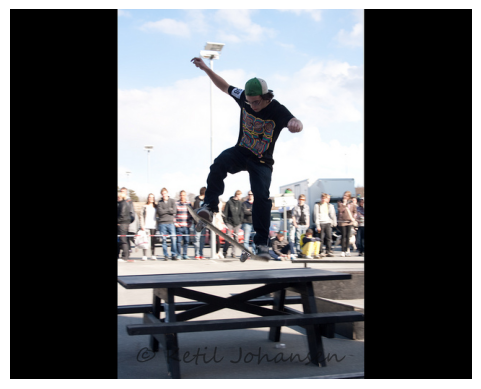

In [22]:
from pycocotools.coco import COCO
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

path = "../../datasets/COCO/images/annotations/captions_val2014.json"

# Initialize COCO API for instance annotations
coco = COCO(path)

# Specify the image ID
image_id = 262148  # Replace with your COCO image ID

# Get image info
img_info = coco.loadImgs(image_id)[0]

# Get the image URL
img_url = img_info['coco_url']

# Download the image
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()


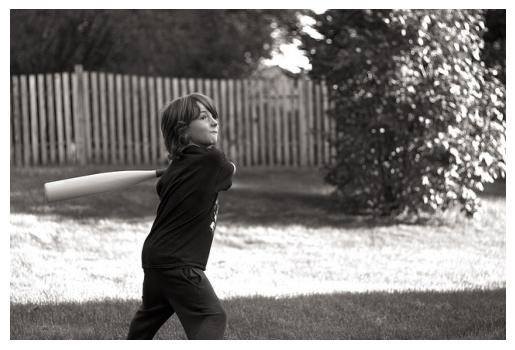

In [28]:
# Specify the image ID
image_id = 131089  # Replace with your COCO image ID

# Get image info
img_info = coco.loadImgs(image_id)[0]

# Get the image URL
img_url = img_info['coco_url']

# Download the image
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()


In [24]:
vqa_test_loader = test_loader['vqa']
evaluator = vqa_test_loader.evaluator
dump_path = os.path.join(args.output, 'karpathy_test_predict.json')
quesid2ans = trainer.vqa_predict(vqa_test_loader, dump_path)

acc_dict_all = evaluator.evaluate_raw(quesid2ans)
acc_dict_answerable = evaluator.evaluate_raw(quesid2ans, is_topk_optimal=True)
acc_dict_unanswerable = evaluator.evaluate_raw(quesid2ans, is_topk_optimal=False)
print(acc_dict_all, acc_dict_answerable, acc_dict_unanswerable)

VQA Validation:   0%|                                                                                                           | 0/4 [00:00<?, ?it/s]

In dataset:In dataset:In dataset: In dataset:   ['vqa: What is he on top of?']['vqa: Where is he looking?'] ['vqa: What color is the grass in this picture?']['vqa: What are the people in the background doing?']         [262148002] [262148000][262148001] 


[131089000]


100%|██████████████████████████████████████████| 4/4 [00:00<00:00, 35469.80it/s]

{'overall': 15.0, 'perQuestionType': {'none of the above': 0.0, 'what are the': 0.0, 'what is': 30.0, 'what color is the': 30.0}, 'perAnswerType': {'other': 15.0}} {'overall': 15.0, 'perQuestionType': {'none of the above': 0.0, 'what are the': 0.0, 'what is': 30.0, 'what color is the': 30.0}, 'perAnswerType': {'other': 15.0}} {'overall': 0, 'perQuestionType': {}, 'perAnswerType': {}}


Below are the ReFT model's answers.

In [26]:
print(quesid2ans)

{262148000: 'on the ground', 262148001: 'skateboarding', 262148002: 'skateboard', 131089000: 'brown'}


You can see that 3 epochs of training already gave ReFT lots of understanding about the image features. For example, for the skateboarding picture, ReFT correctly answers that the person is looking "on the ground", and the person is on top of a "skateboard" (although also on top of the dining table). However, ReFT model fails to answer "What are the people in the background doing" - ReFT considers them as skateboarding too. ReFT also misidentifies the color of the grass as "brown". 

These failure cases potentially show that simply rotating the language model representations are insufficient at identifying the niche relationships between image elements, which potentially are out of the distribution of the training model. Also, a lot of these capabilities might have been picked up while tuning the visual embedding. Potentially tuning more of the visual embedding in compensation to the capability loss of ReFT on images may be a good way to go.